In [ ]:
"""This notebook explores the time to conversion of the pMCI patients

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nibabel
import nibabel.processing
import os
from skimage.filters import threshold_otsu
import cc3d
import pandas as pd
from tqdm.notebook import tqdm, trange

In [2]:
#USE SMALL GPU#
use_gpu = 1 
# The largest memory size GPU is always the first one (0) as they are sorted by size!
gpus=tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[use_gpu], 'GPU')

In [ ]:
#Conv with time excel is taken after processing the ADNI dx dataset. Basically I take the date when they convert 
#and substract that from the first date in the dataset. I did it once in my Windows, if you need the snippet I could
#send it to you

In [3]:
conv=pd.read_excel('conv_with_time.xlsx', header=0, index_col=0,engine='openpyxl')

In [4]:
conv=conv.dropna()

In [5]:
conv

,EXAMDATE,days_to_conv,present
002_S_0729,2007-09-25,418,1.0
002_S_1268,2013-03-14,2178,1.0
003_S_1057,2009-03-05,755,1.0
003_S_1074,2016-03-29,3338,1.0
005_S_0222,2007-03-28,376,1.0
...,...,...,...
137_S_0973,2010-03-07,1181,1.0
137_S_0994,2010-12-10,1451,1.0
141_S_1004,2007-05-11,182,1.0
941_S_1295,2008-08-20,539,1.0


In [6]:
#Borrowed from the 3D preprocessing

def normalize(volume):
    """Normalize the volume"""
    min = volume.min()
    max = volume.max()
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def pp(original_image):
    
    input_img=input_img = nibabel.load("{0}".format(original_image))
    resampled_img = nibabel.processing.conform(input_img, out_shape=(100,100,90), voxel_size=(2.0, 2.0, 2.0))
    
    img = resampled_img.get_fdata()
    
    thresh = threshold_otsu(img)
    bw_img1 = np.copy(img)
    bw_img1[bw_img1 < thresh] = 0
    bw_img1[bw_img1 >= thresh] = 255
    
    input_CCA=bw_img1.astype('int32')
    connectivity = 6
    labels_out, N = cc3d.connected_components(input_CCA, return_N=True)
    
    def mask_largest_label (labels_out, N):
        #print("This function returns the largest blob of a CCA processed image as a binary mask")
        #print("")
        def separate_labels(label_ID, label_matrix):
            mask=1*(label_matrix == label_ID)
            return mask
        labellist=[]
        for j in range(1, N+1):
            a=separate_labels(j, labels_out)
            labellist.append(a)
        #print("The image has {0} labels".format(len(labellist)))
        z=labellist[0]
        #print("The shape of the labels is: {0}".format(z.shape))
        sizelist=[]
        for counter,element in enumerate (labellist):
            a=labellist[counter].sum()
            sizelist.append(a)
        #print("Label sizes: {0}".format(sizelist))
        sizelist=np.asarray(sizelist)
        a=sizelist.argmax()
        #print("The largest label index is: {0}".format(a))
        mask=labellist[a]
        #print("The largest label is now a binary mask with shape {0}, size {1}, max value {2} and min value {3}".format((mask.shape),(mask.sum()),(mask.max()),(mask.min())))
        return mask

    mask=mask_largest_label(labels_out, N)
    
    pimg=np.multiply(img,mask)
    
    return pimg

def process(path):
    """Read and normalize volume"""
    # Read and pp scan
    volume = pp(path)
    # Normalize
    volume = normalize(volume)
    #Prepare for NN input
    volume = np.expand_dims(volume, axis=0)
    volume = np.expand_dims(volume, axis=4)
    return volume

In [7]:
def get_preds(modeldir,directory):
    model=tf.keras.models.load_model(modeldir)
    dire=directory
    
    predictdict={}
    for i in tqdm(os.listdir(dire), desc='Prediction making'):
        volume=process(os.path.join(dire,'{}'.format(i)))
        prediction=model.predict(volume)
        predictdict.update({'{}'.format(i): float(prediction)})
    pdpred=pd.DataFrame.from_dict(data=predictdict, orient="index", columns=["pred"])
    
    return pdpred

In [ ]:
#In a maybe poorly efficient manner, from here on I get predictions from the model and then take also their TTC

## Fold 1

In [9]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn0/epoch16/"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold1/whole"

In [10]:
preds1=get_preds(modeldir,directory)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

In [11]:
fold1=pd.concat([conv, preds1], axis=1)

In [12]:
fold1=fold1.dropna()

In [13]:
fold1

,EXAMDATE,days_to_conv,present,pred
005_S_0222,2007-03-28,376.0,1.0,0.380407
005_S_0448,2014-05-20,2927.0,1.0,0.636046
006_S_1130,2008-07-15,558.0,1.0,0.798445
007_S_0344,2007-04-25,370.0,1.0,0.791755
007_S_0698,2014-11-03,2994.0,1.0,0.586144
009_S_1030,2011-03-01,1569.0,1.0,0.313609
013_S_0325,2008-01-28,580.0,1.0,0.637913
018_S_0155,2009-03-20,1092.0,1.0,0.820480
021_S_0231,2008-03-21,729.0,1.0,0.990844
027_S_0461,2008-01-02,565.0,1.0,0.887413


## Fold 2

In [14]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn1/epoch19"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold2/whole"

In [15]:
preds2=get_preds(modeldir,directory)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

In [16]:
fold2=pd.concat([conv, preds2], axis=1)

011_S_0362 seems to be missing from times

In [17]:
fold2=fold2.dropna()

In [18]:
fold2

,EXAMDATE,days_to_conv,present,pred
003_S_1074,2016-03-29,3338.0,1.0,0.098875
013_S_0860,2008-03-12,513.0,1.0,0.771578
013_S_1186,2015-04-01,2953.0,1.0,0.204250
018_S_0142,2016-03-09,3670.0,1.0,0.728804
027_S_0408,2010-05-10,1452.0,1.0,0.958254
031_S_0294,2008-04-01,711.0,1.0,0.144389
033_S_0513,2009-06-03,1094.0,1.0,0.551737
033_S_0567,2006-12-04,182.0,1.0,0.789106
033_S_0906,2008-04-10,547.0,1.0,0.766828
036_S_0976,2010-02-04,1122.0,1.0,0.381219


## Fold 3

In [19]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn2/epoch17"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold3/whole"

In [20]:
preds3=get_preds(modeldir,directory)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

In [21]:
fold3=pd.concat([conv, preds3], axis=1)

In [22]:
fold3=fold3.dropna()

In [23]:
fold3

,EXAMDATE,days_to_conv,present,pred
005_S_0572,2007-07-12,371.0,1.0,0.768961
005_S_1224,2010-03-12,1123.0,1.0,0.364699
011_S_0326,2009-03-30,1088.0,1.0,0.460061
013_S_0240,2007-11-07,407.0,1.0,0.344416
014_S_0563,2009-07-21,1097.0,1.0,0.932258
016_S_1117,2010-06-24,1291.0,1.0,0.619654
016_S_1326,2008-10-06,559.0,1.0,0.368497
027_S_0256,2006-10-04,182.0,1.0,0.874565
027_S_0835,2008-09-17,733.0,1.0,0.335920
033_S_1116,2009-12-08,1100.0,1.0,0.770155


## Fold 4

In [24]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn3/epoch22"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold4/whole"

In [25]:
preds4=get_preds(modeldir,directory)

Prediction making:   0%|          | 0/74 [00:00<?, ?it/s]

In [26]:
fold4=pd.concat([conv, preds4], axis=1)

In [27]:
fold4=fold4.dropna()

In [28]:
fold4

,EXAMDATE,days_to_conv,present,pred
002_S_1268,2013-03-14,2178.0,1.0,0.672856
007_S_0101,2008-01-08,733.0,1.0,0.228096
007_S_0128,2007-08-22,562.0,1.0,0.817119
011_S_0861,2008-03-25,537.0,1.0,0.274518
011_S_1282,2008-02-28,367.0,1.0,0.324855
016_S_0702,2008-08-21,729.0,1.0,0.273335
035_S_0997,2008-07-31,566.0,1.0,0.601928
037_S_0566,2009-12-18,1222.0,1.0,0.980763
052_S_0671,2014-03-07,2802.0,1.0,0.988830
057_S_1007,2008-11-05,722.0,1.0,0.917202


## Fold 5

In [29]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn4/epoch9"
directory="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold5/whole"

In [30]:
preds5=get_preds(modeldir,directory)

Prediction making:   0%|          | 0/77 [00:00<?, ?it/s]

In [31]:
fold5=pd.concat([conv, preds5], axis=1)

In [32]:
fold5=fold5.dropna()

In [33]:
fold5

,EXAMDATE,days_to_conv,present,pred
002_S_0729,2007-09-25,418.0,1.0,0.188540
003_S_1057,2009-03-05,755.0,1.0,0.946978
012_S_1033,2007-06-25,202.0,1.0,0.329594
014_S_0658,2007-08-14,376.0,1.0,0.369448
018_S_0057,2007-10-29,649.0,1.0,0.785592
018_S_0080,2010-06-08,1602.0,1.0,0.396052
021_S_0141,2007-03-06,370.0,1.0,0.619403
021_S_0626,2014-08-20,2931.0,1.0,0.112108
024_S_1393,2008-10-29,554.0,1.0,0.884049
029_S_1318,2013-03-14,2170.0,1.0,0.047322


In [ ]:
#Here we pool all 5 folds together, similarly to what we did in the MCD notebook

In [34]:
folds=pd.concat([fold1, fold2,fold3,fold4,fold5])

In [35]:
folds

,EXAMDATE,days_to_conv,present,pred
005_S_0222,2007-03-28,376.0,1.0,0.380407
005_S_0448,2014-05-20,2927.0,1.0,0.636046
006_S_1130,2008-07-15,558.0,1.0,0.798445
007_S_0344,2007-04-25,370.0,1.0,0.791755
007_S_0698,2014-11-03,2994.0,1.0,0.586144
...,...,...,...,...
068_S_0872,2012-01-18,1769.0,1.0,0.035844
100_S_0892,2008-10-30,610.0,1.0,0.697404
116_S_0834,2007-12-04,405.0,1.0,0.952729
127_S_0925,2015-11-17,3276.0,1.0,0.784611


# Recall by year

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
results=pd.read_excel("finally_results_dataset.xlsx",engine='openpyxl',index_col=0)

In [3]:
a=list(results['pred'])

In [4]:
b=list(results['days_to_conv'])

In [6]:
oneyear=[]
twoyear=[]
threeyear=[]
fouryear=[]
more=[]

for i,j in enumerate(b):
    if j<365:
        if a[i]>0.31:
            oneyear.append(1)
        else:
            oneyear.append(0)
    elif 365<j<730:
        if a[i]>0.31:
            twoyear.append(1)
        else:
            twoyear.append(0)
    elif 730<j<1095:
        if a[i]>0.31:
            threeyear.append(1)
        else:
            threeyear.append(0)
    elif 1095<j<1460:
        if a[i]>0.31:
            fouryear.append(1)
        else:
            fouryear.append(0)
    elif j>1460:
        if a[i]>0.31:
            more.append(1)
        else:
            more.append(0)

In [5]:
oneyear=[]
twoyear=[]
threeyear=[]
fouryear=[]
more=[]
oy=0
ty=0
triy=0
fy=0
my=0


for i,j in enumerate(b):
    if j<365:
        oy=oy+1
        if a[i]>0.31:
            oneyear.append(1)
        else:
            oneyear.append(0)
    elif j<730:
        ty=ty+1
        if a[i]>0.31:
            twoyear.append(1)
        else:
            twoyear.append(0)
    elif j<1095:
        triy=triy+1
        if a[i]>0.31:
            threeyear.append(1)
        else:
            threeyear.append(0)
    elif j<1460:
        fy=fy+1
        if a[i]>0.31:
            fouryear.append(1)
        else:
            fouryear.append(0)
    elif j>1460:
        my=my+1
        if a[i]>0.31:
            more.append(1)
        else:
            more.append(0)

In [6]:
print("Recall 1 year:",sum(oneyear)/len(oneyear))
print("Recall 2 years:",sum(twoyear)/len(twoyear))
print("Recall 3 years:",sum(threeyear)/len(threeyear))
print("Recall 4 years:",sum(fouryear)/len(fouryear))
print("Recall beyond 4 years:",sum(more)/len(more))
print(oy,ty,triy,fy,my)

Recall 1 year: 0.8571428571428571
Recall 2 years: 0.8205128205128205
Recall 3 years: 0.8571428571428571
Recall 4 years: 0.9285714285714286
Recall beyond 4 years: 0.64
14 39 14 14 25


Text(0.5, 1.0, 'Recall of progressive MCI, 0.5 threshold')

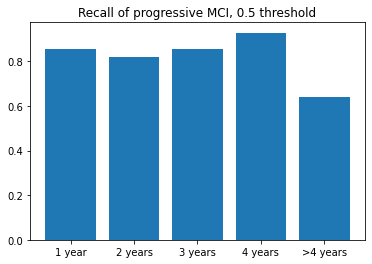

In [13]:
X=['1 year', '2 years','3 years','4 years','>4 years']
y=[sum(oneyear)/len(oneyear),sum(twoyear)/len(twoyear),sum(threeyear)/len(threeyear),
   sum(fouryear)/len(fouryear),sum(more)/len(more)]
plt.bar(X,y)
plt.title("Recall of progressive MCI, 0.5 threshold")